In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
import pickle
from torch.utils.data import Dataset, TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, RobustScaler, MaxAbsScaler
from scipy import stats
from tqdm import tqdm
# from skbio.stats.composition import clr
use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'mps')
print(device)

#from utils import *
### do this explicitly

import optuna

import matplotlib as mpl
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 14

### import comet_ml at the top of your file
'''
from comet_ml import Experiment  ### special library to record performance on a web server
from config import * ### file with personal API_KEY

# later could use comet_ml for hyperparam optm

experiment = Experiment(
    api_key=API_KEY,
    project_name="vae-eco-ml",
    workspace="zireae1",
)
'''

mps


'\nfrom comet_ml import Experiment  ### special library to record performance on a web server\nfrom config import * ### file with personal API_KEY\n\n# later could use comet_ml for hyperparam optm\n\nexperiment = Experiment(\n    api_key=API_KEY,\n    project_name="vae-eco-ml",\n    workspace="zireae1",\n)\n'

### Model

In [2]:
## double decoder version:
## 1 decoder for binary output and 1 for reconstruction
class VAE_2(nn.Module):
    def __init__(self, input_dim, latent_dim=64, hidden_dim=1024, dropout_rate=0.1):
        super(VAE_2, self).__init__()
        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )
        self.get_mu = nn.Sequential(
            nn.Linear(hidden_dim, latent_dim), 
            nn.BatchNorm1d(latent_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )
        self.get_logvar = nn.Sequential(
            nn.Linear(hidden_dim, latent_dim), 
            nn.BatchNorm1d(latent_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )
        self.decoder_b = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim), 
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )
        self.decoder_nb = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim), 
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim), 
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Tanh()
        )
        
    def encode(self, x):
        h = self.encoder(x)
        mu = self.get_mu(h)
        logvar = self.get_logvar(h)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        binary = self.decoder_b(z)
        nonbinary = self.decoder_nb(z)
        return binary, nonbinary, mu, logvar

def compute_loss_2(model, features, labels, weights):
    b, nb, mu, logvar = model(features)
    mask = (labels!=-1).float()
    
    bce_loss = F.binary_cross_entropy(b, mask, reduction='sum')
    recon_loss = torch.sum(F.mse_loss(nb, labels, reduction="none") * mask)

    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    loss = weights[0]*recon_loss + weights[1]*bce_loss + weights[2]*kl_loss
    return b, nb, loss, weights[0]*recon_loss, weights[1]*bce_loss, weights[2]*kl_loss


### Load, split and normalize the data

In [3]:
def load_filtered_data(p_data):
    features = torch.load(p_data)["features"]
    labels = torch.load(p_data)["labels"]
    spc_names = torch.load(p_data)["names"]
    
    original_indices = np.arange(len(features))
    train_indices, test_indices = train_test_split(
        original_indices,
        test_size=0.2,
        random_state=42,
    )
    X_train = features[train_indices]
    X_test = features[test_indices]
    y_train = labels[train_indices]
    y_test = labels[test_indices]
#     X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

    ## clr transformation for outputs
    zero_thr = 1e-8
    gmean_train = (np.exp(np.nansum(np.log(y_train[y_train > 0]+zero_thr)) / np.size(y_train)))
    y_train_clr = np.log((y_train+zero_thr)/gmean_train)
    y_test_clr = np.log((y_test+zero_thr)/gmean_train)

    ## rescale the data
    scaler = preprocessing.MaxAbsScaler().fit(y_train_clr)
    # scaler = preprocessing.RobustScaler().fit(y_train_clr)
    y_train_scaled = scaler.transform(y_train_clr)
    y_test_scaled = scaler.transform(y_test_clr)

    ## transform to tensors
    X_train_scaled=torch.from_numpy(X_train).float()
    y_train_scaled=torch.from_numpy(y_train_scaled).float()
    X_test_scaled=torch.from_numpy(X_test).float()
    y_test_scaled=torch.from_numpy(y_test_scaled).float()

#     plt.hist(y_test_scaled.numpy().flatten(), bins=40)
#     plt.yscale("log")
#     plt.xlabel("Abundance score")
#     plt.ylabel("Counts")
#     plt.show()
    
    # keep the spc names and train/test split for evaluation use
    return X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, {"spcs":spc_names,
                                                                          "train_idx": train_indices, 
                                                                          "test_idx": test_indices}

### Implement VAE

In [4]:
class VAETrainer:
    def __init__(self, model, train_loader, test_loader, optimizer, weights, device="cuda:0"):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.optimizer = optimizer
        self.weights = weights
        self.device = device

    def train_one_epoch(self, zero_thr):
        self.model.train()
        total_loss, total_recon_loss, total_bce_loss, total_kl_loss = 0, 0, 0, 0
        total_acc = 0
        total_len = 0
        for batch in self.train_loader:
            if batch['Features'].size(0) == 1:
                continue 
            batch['Features'], batch['Labels'] = batch['Features'].to(device), batch['Labels'].to(device)
            
            self.optimizer.zero_grad()
#             recon_x, loss, recon_loss, kl_loss = compute_loss(self.model, batch['Features'], batch['Labels'], self.weights)
            b, nb, loss, recon_loss, bce_loss, kl_loss = compute_loss_2(self.model, batch['Features'], batch['Labels'], self.weights)
            loss.backward()
            self.optimizer.step()
            
            total_loss += loss.item()
            total_recon_loss += recon_loss.item()
            total_bce_loss += bce_loss.item()
            total_kl_loss += kl_loss.item()
            
#             out = ((recon_x.detach())>zero_thr).float()
            out = (b.detach()>0.5).float()
            total_acc += (out == batch['Features']).float().sum().item() # for binary-abundance
            total_len += batch["Features"].shape[0]

        return total_loss / total_len, \
               total_recon_loss / total_len, \
               total_bce_loss / total_len, \
               total_kl_loss / total_len, \
               total_acc / total_len / batch["Features"].shape[1]

    @torch.no_grad()
    def test_one_epoch(self, zero_thr):
        self.model.eval()
        total_loss, total_recon_loss, total_bce_loss, total_kl_loss = 0, 0, 0, 0
        total_acc = 0
        total_len = 0
        for batch in self.test_loader:
            batch['Features'], batch['Labels'] = batch['Features'].to(device), batch['Labels'].to(device)
            
#             recon_x, loss, recon_loss, kl_loss = compute_loss(self.model, batch['Features'], batch['Labels'], self.weights)
            b, nb, loss, recon_loss, bce_loss, kl_loss = compute_loss_2(self.model, batch['Features'], batch['Labels'], self.weights)
            
            total_loss += loss.item()
            total_recon_loss += recon_loss.item()
            total_bce_loss += bce_loss.item()
            total_kl_loss += kl_loss.item()
            
#             out = ((recon_x.detach())>zero_thr).float()
            out = (b.detach()>0.5).float()
            total_acc += (out == batch['Features']).float().sum().item() # for binary-abundance
            total_len += batch["Features"].shape[0]

        return total_loss / total_len, \
               total_recon_loss / total_len, \
               total_bce_loss / total_len, \
               total_kl_loss / total_len, \
               total_acc / total_len / batch["Features"].shape[1]

### Optimization

In [5]:
p_data="../../data/orig_Species_filtered_10000.pt"
#p_output="../models/orig_Species_10000_trained_AE.pt"


X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, annotations = load_filtered_data(p_data)
spc_names = annotations["spcs"]
class CustomDataset(Dataset):
    def __init__(self, features, labels, device=None):
        self.labels = labels
        self.features = features
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        label = self.labels[idx]
        data = self.features[idx]
        return {"Features": data, "Labels": label}
Train = CustomDataset(X_train_scaled, y_train_scaled)
Test = CustomDataset(X_test_scaled, y_test_scaled)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def objective(trial):
    # Suggest hyperparameters
    input_dim = len(spc_names)
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
    latent_dim = trial.suggest_categorical('latent_dim', [32, 64, 128, 256, 512, 1024, 2048, 4096])
    hidden_dim = trial.suggest_categorical('hidden_dim', [256, 512, 1024, 2048, 4096])
    dropout = trial.suggest_float('dropout', 0.0, 0.5)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-2)
    
    #w1 = trial.suggest_float('w1', 0.0, 1.0)
    #w2 = trial.suggest_float('w2', 0.0, 1.0)
    #w3 = trial.suggest_float('w3', 0.0, 1.0)
    
    weights=[1.0, 1.0, 0]
    
    zero_thr = -0.8
    epochs = 50
    
    # Build and train your VAE with these hyperparameters
    model = VAE_2(input_dim=input_dim, latent_dim=latent_dim, hidden_dim=hidden_dim, dropout_rate=dropout).to(device)
    optimizer = torch.optim.AdamW(
        model.parameters(), 
        lr=lr,
        weight_decay=weight_decay
    )
    
    # Train the model and return the validation loss
    ## create batch spits of data
    kwargs = {'num_workers': 4, 'pin_memory': True} if use_cuda else {}
    train_DS = DataLoader(Train, batch_size=100, shuffle=True, drop_last=False, **kwargs)
    test_DS = DataLoader(Test, batch_size=100, shuffle=True, drop_last=False, **kwargs)

    trainer = VAETrainer(model, train_DS, test_DS, optimizer, weights, device)

    train_losses = []
    test_losses = []
    train_acc = []
    test_acc = []
    MSEs, BCEs, KLDs = [], [], []
    for epoch in tqdm(range(epochs)):
        train_loss, MSE, BCE, KLD, acc = trainer.train_one_epoch(zero_thr)
        train_losses.append(train_loss)
        train_acc.append(acc)

        test_loss, MSE, BCE, KLD, acc = trainer.test_one_epoch(zero_thr)
        test_losses.append(test_loss)
        test_acc.append(acc)
        MSEs.append(MSE)
        BCEs.append(BCE)
        KLDs.append(KLD)
    
    # Compute model size
    model_size = count_parameters(model)
    
    return test_loss, model_size

study = optuna.create_study(directions=["minimize", "minimize"])
study.optimize(objective, n_trials=250)
#print(study.best_params) ### if we optimize just one direction

[I 2025-08-05 03:44:06,361] A new study created in memory with name: no-name-eeef3373-1042-4d0a-a32d-a918c50395bd
/var/folders/p_/d3sw5v2959q517kbbgtv7cjw0000gq/T/ipykernel_63737/3016820883.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
/var/folders/p_/d3sw5v2959q517kbbgtv7cjw0000gq/T/ipykernel_63737/3016820883.py:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-2)
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [02:27<00:00,  2.95s/it]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [02:35<00:00,  3.10s/it]
[I 2025-08-05 04:23:57,582] Trial 15 finished with values: [73.65799462890625, 21353398.0] and parameters: {'lr': 0.00029022738889763794, 'latent_dim': 64, 'hidden_dim': 4096, 'dropout': 0.4276063951121375, 'weight_decay': 0.0029709676007061633}.
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [02:26<00:00,  2.93s/it]
[I 2025-08-05 04:26:24,054] Trial 16 finished with values: [13.358580688476563, 14352950.0] and parameters: {'lr': 0.0016556254953436524, 'latent_dim': 1024, 'hidden_dim': 2048, 'dropout': 0.38073091521271313, 'weight_decay': 4.141087624383497e-05}.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [02:23<00:00,  2.87s/it]
[I 2025-08-05 05:10:50,383] Trial 34 finished with values: [79.58945336914063, 418358.0] and parameters: {'lr': 4.087619707783087e-05, 'latent_dim': 128, 'hidden_dim': 256, 'dropout': 0.06009278365529991, 'weight_decay': 6.226346644100608e-05}.
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [02:25<00:00,  2.91s/it]
[I 2025-08-05 05:13:15,797] Trial 35 finished with values: [55.548109375, 2980918.0] and parameters: {'lr': 9.57013506601575e-05, 'latent_dim': 256, 'hidden_dim': 1024, 'dropout': 0.19652847497271092, 'weight_decay': 0.00023303967268901074}.
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [02:49<00:00,  3.38s/it]
[I 2025-08-05 05:57:59,361] Trial 53 finished with values: [3.225720245361328, 87437878.0] and parameters: {'lr': 0.00010785134724752663, 'latent_dim': 4096, 'hidden_dim': 4096, 'dropout': 0.043713156041100265, 'weight_decay': 0.00021077261660615494}.
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [02:26<00:00,  2.93s/it]
[I 2025-08-05 06:00:25,707] Trial 54 finished with values: [87.56761254882812, 1341238.0] and parameters: {'lr': 1.1753833461309116e-05, 'latent_dim': 1024, 'hidden_dim': 256, 'dropout': 0.23292994848892645, 'weight_decay': 1.8299668034957276e-05}.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [02:21<00:00,  2.84s/it]
[I 2025-08-05 06:44:47,002] Trial 72 finished with values: [57.6904462890625, 418358.0] and parameters: {'lr': 0.0011008762161190224, 'latent_dim': 128, 'hidden_dim': 256, 'dropout': 0.26971423183248716, 'weight_decay': 4.114589066021446e-05}.
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [02:24<00:00,  2.89s/it]
[I 2025-08-05 06:47:11,528] Trial 73 finished with values: [82.97096484375, 1341238.0] and parameters: {'lr': 2.5503697949416814e-05, 'latent_dim': 1024, 'hidden_dim': 256, 'dropout': 0.4685153941569599, 'weight_decay': 0.0028547423002642978}.
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [02:28<00:00,  2.96s/it]
[I 2025-08-05 07:31:57,366] Trial 91 finished with values: [49.2493798828125, 1229366.0] and parameters: {'lr': 0.00997994356687238, 'latent_dim': 256, 'hidden_dim': 512, 'dropout': 0.36906074052850624, 'weight_decay': 0.0015366121690271357}.
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [02:27<00:00,  2.95s/it]
[I 2025-08-05 07:34:24,730] Trial 92 finished with values: [33.43113427734375, 8056886.0] and parameters: {'lr': 0.0014459595982129476, 'latent_dim': 256, 'hidden_dim': 2048, 'dropout': 0.32861936784305623, 'weight_decay': 2.1481392150053203e-05}.
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [02:29<00:00,  2.98s/it]
[I 2025-08-05 08:18:40,493] Trial 110 finished with values: [18.807907897949217, 14352950.0] and parameters: {'lr': 0.0003824211765240525, 'latent_dim': 1024, 'hidden_dim': 2048, 'dropout': 0.4685153941569599, 'weight_decay': 0.002633734421784717}.
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [02:26<00:00,  2.94s/it]
[I 2025-08-05 08:21:07,336] Trial 111 finished with values: [32.49474169921875, 2455862.0] and parameters: {'lr': 0.000579143129754614, 'latent_dim': 128, 'hidden_dim': 1024, 'dropout': 0.015359191241134107, 'weight_decay': 1.98797961942729e-05}.
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [02:27<00:00,  2.95s/it]
[I 2025-08-05 09:05:42,882] Trial 129 finished with values: [21.391282592773436, 2980918.0] and parameters: {'lr': 0.0003686508818065022, 'latent_dim': 256, 'hidden_dim': 1024, 'dropout': 0.00937026146829295, 'weight_decay': 3.7784678590189794e-05}.
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [02:31<00:00,  3.04s/it]
[I 2025-08-05 09:08:14,954] Trial 130 finished with values: [7.110903503417969, 18732598.0] and parameters: {'lr': 0.0021385832722501034, 'latent_dim': 4096, 'hidden_dim': 1024, 'dropout': 0.04765636700655207, 'weight_decay': 4.159421007371049e-05}.
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [02:22<00:00,  2.85s/it]
[I 2025-08-05 09:53:14,316] Trial 148 finished with values: [75.9213271484375, 1755190.0] and parameters: {'lr': 3.404041532865818e-05, 'latent_dim': 512, 'hidden_dim': 512, 'dropout': 0.41671964113350124, 'weight_decay': 0.00043070486427324657}.
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [02:24<00:00,  2.89s/it]
[I 2025-08-05 09:55:38,900] Trial 149 finished with values: [28.84944287109375, 2980918.0] and parameters: {'lr': 0.0003824211765240525, 'latent_dim': 256, 'hidden_dim': 1024, 'dropout': 0.1511037678875582, 'weight_decay': 0.0010419703218403865}.
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [02:28<00:00,  2.98s/it]
[I 2025-08-05 10:40:24,319] Trial 167 finished with values: [12.899189270019532, 18732598.0] and parameters: {'lr': 0.00480225481685459, 'latent_dim': 4096, 'hidden_dim': 1024, 'dropout': 0.3759645591046875, 'weight_decay': 0.0007109701842735433}.
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [02:26<00:00,  2.92s/it]
[I 2025-08-05 10:42:50,488] Trial 168 finished with values: [81.54136938476563, 6482870.0] and parameters: {'lr': 0.0006305359855059955, 'latent_dim': 64, 'hidden_dim': 2048, 'dropout': 0.4703321522227195, 'weight_decay': 4.114589066021446e-05}.
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [02:25<00:00,  2.91s/it]
[I 2025-08-05 11:26:25,354] Trial 186 finished with values: [52.0279521484375, 2980918.0] and parameters: {'lr': 0.0007130032960533752, 'latent_dim': 256, 'hidden_dim': 1024, 'dropout': 0.4685153941569599, 'weight_decay': 3.383148245330149e-05}.
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [02:47<00:00,  3.34s/it]
[I 2025-08-05 11:29:12,829] Trial 187 finished with values: [3.1428294525146483, 87437878.0] and parameters: {'lr': 0.00010785134724752663, 'latent_dim': 4096, 'hidden_dim': 4096, 'dropout': 0.09693029342683362, 'weight_decay': 0.00043040099309224743}.
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [02:27<00:00,  2.95s/it]
[I 2025-08-05 12:13:17,175] Trial 205 finished with values: [29.9099072265625, 1229366.0] and parameters: {'lr': 0.0006503387425582593, 'latent_dim': 256, 'hidden_dim': 512, 'dropout': 0.12847272087453165, 'weight_decay': 0.0003283692218451411}.
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [02:29<00:00,  2.98s/it]
[I 2025-08-05 12:15:46,323] Trial 206 finished with values: [46.98244873046875, 2395958.0] and parameters: {'lr': 0.00011105432690562609, 'latent_dim': 2048, 'hidden_dim': 256, 'dropout': 0.07912890031204944, 'weight_decay': 1.4404897779392952e-05}.
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [02:20<00:00,  2.81s/it]
[I 2025-08-05 13:00:22,274] Trial 224 finished with values: [79.390046875, 769270.0] and parameters: {'lr': 0.00480225481685459, 'latent_dim': 32, 'hidden_dim': 512, 'dropout': 0.3224489162018722, 'weight_decay': 0.0003283692218451411}.
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [02:18<00:00,  2.78s/it]
[I 2025-08-05 13:02:41,123] Trial 225 finished with values: [63.75527319335937, 769270.0] and parameters: {'lr': 0.0007130032960533752, 'latent_dim': 32, 'hidden_dim': 512, 'dropout': 0.08472091738406912, 'weight_decay': 0.002637988639896617}.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [02:26<00:00,  2.93s/it]
[I 2025-08-05 13:46:45,248] Trial 243 finished with values: [11.489020935058594, 18732598.0] and parameters: {'lr': 0.00997994356687238, 'latent_dim': 4096, 'hidden_dim': 1024, 'dropout': 0.18910371724667396, 'weight_decay': 0.00011347444411615583}.
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [02:24<00:00,  2.90s/it]
[I 2025-08-05 13:49:10,052] Trial 244 finished with values: [34.0215263671875, 4505398.0] and parameters: {'lr': 0.00018247603895800608, 'latent_dim': 4096, 'hidden_dim': 256, 'dropout': 0.09693029342683362, 'weight_decay': 0.00043040099309224743}.
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

In [6]:
### save the study
import pickle

with open("optuna_study_250.pkl", "wb") as f:
    pickle.dump(study, f)

In [7]:
### load the study and plot pareto
with open("optuna_study_250.pkl", "rb") as f:
    study = pickle.load(f)
    
fig = optuna.visualization.plot_pareto_front(
    study,
    targets=lambda t: (t.values[0], t.values[1]),
    target_names=["test_loss", "model_size"]
)

fig.show()

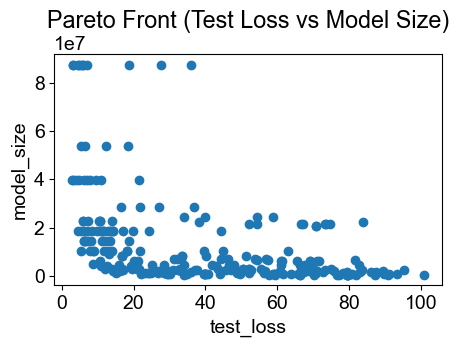

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 3))
trials = [(t.values[0], t.values[1]) for t in study.trials if t.values is not None]
x, y = zip(*trials)
plt.scatter(x, y)
plt.xlabel("test_loss")
plt.ylabel("model_size")
plt.title("Pareto Front (Test Loss vs Model Size)")

plt.show()

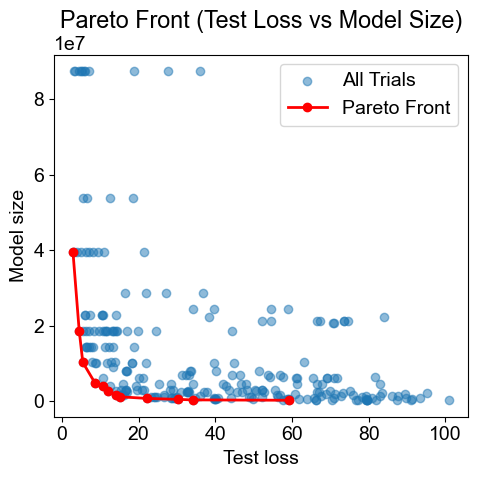

In [9]:
import matplotlib.pyplot as plt

# Extract all trials with valid values
all_trials = [(t.values[0], t.values[1]) for t in study.trials if t.values is not None]

# Extract Pareto front trials
pareto_trials = study.best_trials
pareto_points = [(t.values[0], t.values[1]) for t in pareto_trials]

# Sort Pareto points by test_loss for plotting
pareto_points = sorted(pareto_points, key=lambda p: p[0])

# Plot
plt.figure(figsize=(5, 5))
x_all, y_all = zip(*all_trials)
plt.scatter(x_all, y_all, label='All Trials', alpha=0.5)

x_pareto, y_pareto = zip(*pareto_points)
plt.plot(x_pareto, y_pareto, color='red', linewidth=2, marker='o', label='Pareto Front')

plt.xlabel("Test loss")
plt.ylabel("Model size")
plt.title("Pareto Front (Test Loss vs Model Size)")
plt.legend()
plt.tight_layout()
plt.savefig(f"../figures/pareto_model_param_optimization_upd.pdf", bbox_inches="tight")
   
plt.show()

In [11]:
pareto_trials

[FrozenTrial(number=99, state=TrialState.COMPLETE, values=[15.17159161376953, 1229366.0], datetime_start=datetime.datetime(2025, 8, 5, 7, 49, 2, 915605), datetime_complete=datetime.datetime(2025, 8, 5, 7, 51, 28, 869347), params={'lr': 0.002845869663226317, 'latent_dim': 256, 'hidden_dim': 512, 'dropout': 0.00937026146829295, 'weight_decay': 3.7784678590189794e-05}, user_attrs={}, system_attrs={'NSGAIISampler:generation': 1}, intermediate_values={}, distributions={'lr': FloatDistribution(high=0.01, log=True, low=1e-05, step=None), 'latent_dim': CategoricalDistribution(choices=(32, 64, 128, 256, 512, 1024, 2048, 4096)), 'hidden_dim': CategoricalDistribution(choices=(256, 512, 1024, 2048, 4096)), 'dropout': FloatDistribution(high=0.5, log=False, low=0.0, step=None), 'weight_decay': FloatDistribution(high=0.01, log=True, low=1e-05, step=None)}, trial_id=99, value=None),
 FrozenTrial(number=102, state=TrialState.COMPLETE, values=[11.994559539794922, 2806838.0], datetime_start=datetime.date

In [20]:
best_loss_trial = min(study.best_trials, key=lambda t: t.values[0])
print(f"Lowest test_loss trial (#{best_loss_trial.number}):")
print(f"  test_loss: {best_loss_trial.values[0]}")
print(f"  model_size: {best_loss_trial.values[1]}")
print(f"  Params: {best_loss_trial.params}")


Lowest test_loss trial (#24):
  test_loss: 4.068532836914063
  model_size: 18732598.0
  Params: {'lr': 0.0004082266590989396, 'latent_dim': 4096, 'hidden_dim': 1024, 'dropout': 0.06788556680507996, 'weight_decay': 4.7012425746663086e-05}
